In [20]:
import hydra
import hydra.experimental
import numpy as np
import tqdm
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer
from omegaconf import DictConfig

from torchfly.text.decode import TransformerDecoder
from torchfly.common import set_random_seed, move_to_device

from configure_dataloader import DataLoaderHandler
from model import Generator, TextGAILModel

import logging
import matplotlib.pyplot as plt
import matplotlib

In [21]:
set_random_seed(12)

12

In [22]:
hydra.experimental.initialize("config")

ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

In [23]:
config = hydra.experimental.compose("config.yaml")
print(config.pretty())

task:
  name: CommonGEN
  data_dir: ../../data/CommonGEN
  mle_weights_path: ../MLE/outputs/CommonGEN/Checkpoints/iter_252_model_state.pth
  textgail_weights_path: ../TextGAIL/outputs/CommonGEN/Checkpoints/iter_999_model_state.pth
training:
  random_seed: 1
  num_gpus_per_node: 1
  batch_size: 32
  resume:
    resume: false
    resume_model: true
    resume_optimizer: true
    resume_scheduler: true
    resume_rng_state: true
  total_num:
    epochs: -1
    update_steps: 1000
  validation:
    steps_interval: 100
  checkpointing:
    directory: Checkpoints
    steps_interval: 100
    seconds_interval: -1
    num_checkpoints_to_keep: 1000
    keep_checkpoint_every_num_seconds: 86400
  logging:
    level: INFO
    steps_interval: -1
    seconds_interval: 2
  optimization:
    fp16: false
    fp16_opt_level: O1
    optimizer_name: AdamW
    learning_rate: 1.0e-05
    gradient_accumulation_steps: 1
    weight_decay: 0.01
    max_gradient_norm: -1.0
    warmup:
      scheduler_name: WarmupL

In [24]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [25]:
dataloader_handler = DataLoaderHandler(config)
test_dataloader = dataloader_handler.test_dataloader(config)
collate_fn = test_dataloader.dataset.collate_fn

In [26]:
device = torch.device("cuda")

In [27]:
model = TextGAILModel(config)
model = model.cuda()

In [28]:
temperatures = (np.arange(3, 10, 1) + 1) / 10.0
print(temperatures)

[0.4 0.5 0.6 0.7 0.8 0.9 1. ]


## MLE

In [29]:
print(config.task.mle_weights_path)
mle_weights = torch.load(config.task.mle_weights_path)
model.generator.load_state_dict(mle_weights)

../MLE/outputs/CommonGEN/Checkpoints/iter_252_model_state.pth


<All keys matched successfully>

In [30]:
mle = []
for temperature in temperatures:
    for batch in tqdm.tqdm(test_dataloader):
        batch = collate_fn(batch)
        batch = move_to_device(batch, device)
        batch["temperature"] = temperature

        model.predict(batch)
    metrics = model.get_metrics(reset=True)
    mle.append(metrics['perplexity'])

100%|██████████| 189/189 [00:10<00:00, 18.06it/s]


In [31]:
print(mle)

[76.83318922254774, 36.25436051686605, 22.868459979062358, 17.143013338563303, 14.443468643874718, 13.284154654810669, 13.109475489015933]


## TextGAIL

In [32]:
print(config.task.textgail_weights_path)

../TextGAIL/outputs/CommonGEN/Checkpoints/iter_999_model_state.pth


In [33]:
textgail_weights = torch.load(config.task.textgail_weights_path)
model.load_state_dict(textgail_weights)

<All keys matched successfully>

In [34]:
textgail = []
for temperature in temperatures:
    for batch in tqdm.tqdm(test_dataloader):
        batch = collate_fn(batch)
        batch = move_to_device(batch, device)
        batch["temperature"] = temperature

        model.predict(batch)
    metrics = model.get_metrics(reset=True)
    textgail.append(metrics['perplexity'])

100%|██████████| 189/189 [00:10<00:00, 18.00it/s]


In [35]:
print(textgail)

[44.69564094745293, 34.28710946582613, 31.955918165741775, 33.39864908450495, 37.68774115345465, 44.91093532622806, 55.631181636184614]


## Plot

In [38]:
# write results
with open(f"{config.task.name}_perplexity.txt", "w") as f:
    line = json.dumps({"mle": mle, "textgail": textgail})
    f.write(line)
    f.write("\n")

In [36]:
config.task.name = "CommonGEN"

In [39]:
with open(f"{config.task.name}_perplexity.txt") as f:
    line = f.readline()
    line = json.loads(line)
    mle = line["mle"]
    textgail = line["textgail"]

In [40]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

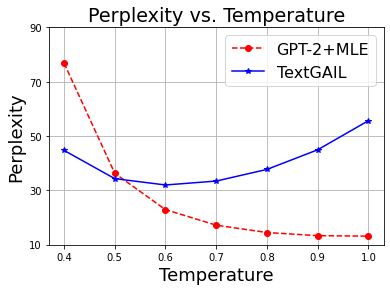

In [41]:
fig=plt.figure()
ax = fig.add_subplot(111)
matplotlib.rcParams.update({'font.size': 16})

ax.plot(temperatures, mle, marker="o", color="r", ls="--")
ax.plot(temperatures, textgail, marker="*", color="b")
ax.legend(["GPT-2+MLE", "TextGAIL"])
ax.set_xlabel("Temperature", fontsize=18)
ax.set_ylabel("Perplexity", fontsize=18)
ax.set_title(f"Perplexity vs. Temperature")

major_ticks = np.arange(10, 100, 20)
ax.set_yticks(major_ticks)
ax.set_xticks(temperatures)

ax.grid("on")

plt.savefig(f"{config.task.name} perplexity.png", dpi=300, pad_inches=0.1, bbox_inches='tight')